# Working with parametrised Boolean networks

This part of AEON.py library offers basic functionality for working with Boolean networks. In particular, it supports **three major formats** (`.bnet`, `.sbml`, and `.aeon`), can perform basic **integrity checks** (e.g. that an update function only uses variables that are actually declared as regulators, etc.), and can be used to run simple operations on the regulatory graph (like decomposition into **strongly connected components**).

However, there are two features in particular that (as of now) are uniquely implemented only in this library:
 
 - Support for fully symbolic exploration of the asynchronous dynamics of a Boolean network (using `SymbolicAsyncGraph`). With this functionality, you can typically explore the dynamics of networks with tens or hundreds of variables without significant state space explosion.
 - Support for "parametrised" networks, where the transitions possibly depend on unknown (uninterpreted) functions. For example, this means that if your data isn't sufficient to actually produce a single "correct" network, you can automatically work with a collection of networks with different dynamical constraints.

As always, the library lives on PyPi, so you can simple get it through pip (`pip install biodivine_boolean_networks`), and use it:

In [1]:
from biodivine_aeon import *

If you have an existing model that you want to work with, you can load it right away as a Boolean network. Here, we will use (for demonstration) a very simple model with 5 variables:

In [2]:
from pathlib import Path

g2a = BooleanNetwork.from_file('g2a.sbml')

# You can also use:
# BooleanNetwork.from_sbml(...)
# BooleanNetwork.from_bnet(...)
# BooleanNetwork.from_aeon(...)
# However, these accept the model string representation, not the file path.

g2a.num_vars()

5

Similarly, if you already have a Boolean network, you can easily output it to one of these formats using a `to_*` method. Just keep in mind that every format has slightly different capabilities (for example, `bnet` does not keep track of the underlying regulatory graph, so this information will be lost).

In [3]:
print(g2a.to_sbml())

<?xml version='1.0' encoding='UTF-8' standalone='no'?><sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" layout:required="false" level="3" qual:required="true" xmlns:layout="http://www.sbml.org/sbml/level3/version1/layout/version1" version="1" xmlns:qual="http://www.sbml.org/sbml/level3/version1/qual/version1"><model><qual:listOfQualitativeSpecies xmlns:qual="http://www.sbml.org/sbml/level3/version1/qual/version1"><qual:qualitativeSpecies qual:maxLevel="1" qual:constant="false" qual:name="CcrM" qual:id="CcrM"/><qual:qualitativeSpecies qual:maxLevel="1" qual:constant="false" qual:name="CtrA" qual:id="CtrA"/><qual:qualitativeSpecies qual:maxLevel="1" qual:constant="false" qual:name="DnaA" qual:id="DnaA"/><qual:qualitativeSpecies qual:maxLevel="1" qual:constant="false" qual:name="GcrA" qual:id="GcrA"/><qual:qualitativeSpecies qual:maxLevel="1" qual:constant="false" qual:name="SciP" qual:id="SciP"/></qual:listOfQualitativeSpecies><qual:listOfTransitions xmlns:qual="http://www.sbml

In [4]:
print(g2a.to_bnet())

targets,factors
CcrM, ((CtrA & !CcrM) & !SciP)
CtrA, (((CtrA & !CtrA) | ((((!CtrA & GcrA) & !CcrM) & !SciP) & (CtrA | !CtrA))) | ((CtrA & !CcrM) & !SciP))
DnaA, (((CtrA & !GcrA) & !DnaA) & CcrM)
GcrA, (!CtrA & DnaA)
SciP, (CtrA & !DnaA)



In [5]:
print(g2a.to_aeon())

CtrA -> CtrA
GcrA -> CtrA
CcrM -| CtrA
SciP -| CtrA
CtrA -| GcrA
DnaA -> GcrA
CtrA -> DnaA
GcrA -| DnaA
DnaA -| DnaA
CcrM -> DnaA
CtrA -> CcrM
CcrM -| CcrM
SciP -| CcrM
CtrA -> SciP
DnaA -| SciP
$CcrM: ((CtrA & !CcrM) & !SciP)
$CtrA: ((false | ((((!CtrA & GcrA) & !CcrM) & !SciP) & true)) | ((CtrA & !CcrM) & !SciP))
$DnaA: (((CtrA & !GcrA) & !DnaA) & CcrM)
$GcrA: (!CtrA & DnaA)
$SciP: (CtrA & !DnaA)



### Regulatory Graphs

Now, if you want to create your network in code, you have to first create its `RegulatoryGraph`. A regulatory graph consists simply of variables connected using regulation edges. Each regulation edge can have a monotonicity (`activation` or `inhibition`), and can be observable (`true` or `false`). Monotonicity means that once we try to assign actual Boolean function to this regulation, it must be non-decreasing or non-increasing in the input coresponding to the regulator. Meanwhile, an observable regulation must have an impact on the regulated variable, while non-observable may simply omit the regulation.

In [6]:
# To create a regulatory graph, you give it a list of variables that you want to create
rg = RegulatoryGraph(["a", "b", "c"])
rg.variables()

[VariableId(0), VariableId(1), VariableId(2)]

Notice that the variables in the regulatory graph are identified using `VariableId` objects. This is mostly to avoid working with name strings outside of the Boolean network or regulatory graph in Rust. However, most Python bindings should happily accept both a variable name or a `VariableId` object.

You can always translate between the two easily:

In [7]:
rg.get_variable_name(rg.variables()[1])

'b'

In [8]:
rg.find_variable("c")

VariableId(2)

Now, we can start adding regulations to our graph. Notice that monotonicity and observability are optional and will use default value when not provided.

In [9]:
rg.add_regulation({ "source": "a", "target": "b", "monotonicity": "activation", "observable": True })

rg.add_regulation({ "source": "b", "target": "c" }) # monotonicity = none, observable = false
rg.add_regulation({ "source": "b", "target": "a" })

rg.add_regulation({ "source": "a", "target": "a" }) # autoregulations
rg.add_regulation({ "source": "c", "target": "c" })

rg.regulations()

[{'source': VariableId(0),
  'target': VariableId(1),
  'monotonicity': 'activation',
  'observable': True},
 {'source': VariableId(1), 'target': VariableId(2), 'observable': True},
 {'source': VariableId(1), 'target': VariableId(0), 'observable': True},
 {'source': VariableId(0), 'target': VariableId(0), 'observable': True},
 {'source': VariableId(2), 'target': VariableId(2), 'observable': True}]

In [10]:
rg.find_regulation("a", "b")

{'source': VariableId(0),
 'target': VariableId(1),
 'monotonicity': 'activation',
 'observable': True}

Once we have a graph, we can perform some basic exploration of its structure:

In [11]:
rg.regulators("b")

{VariableId(0)}

In [12]:
rg.targets("b")

{VariableId(0), VariableId(2)}

In [13]:
rg.regulators_transitive("b")

{VariableId(0), VariableId(1)}

In [14]:
rg.targets_transitive("b")

{VariableId(0), VariableId(1), VariableId(2)}

We can even run a simple SCC decomposition algorithm which will reveal variables that are mutually influencing each other. Here, we know that `a` and `b` have a cycle together, and `c` is only influenced by `b`.

In [15]:
rg.strongly_connected_components()

[{VariableId(2)}, {VariableId(0), VariableId(1)}]

If we already have a Boolean network, we can easily obtain its regulatory graph:

In [16]:
g2a.graph().strongly_connected_components()

[{VariableId(0), VariableId(1), VariableId(2), VariableId(3), VariableId(4)}]

In this case, we see that the g2a network has only one component, consisting of all its variables.

### Update Functions and Parameters

A Boolean network is essentially a regulatory graph with update functions. However, as we mentioned above, our Boolean networks can also contain functions that are either unknown, or partially defined using logical parameters and uninterpreted Boolean functions.

In [17]:
# Create a Boolean network with a fixed regulatory graph
bn = BooleanNetwork(rg)

# Initially, all update functions are undefined:
print(bn.get_update_function("a"))

# Such undefined functions are also referred to as "implicit parameters".
print(bn.implicit_parameters())

None
[VariableId(0), VariableId(1), VariableId(2)]


We can still work with such a network, but in this case, our implementation of `SymbolicAsyncGraph` would consider **every possible** update function for every variable (as long as it satisfies requirements on regulation observability and monotonicity). That is mostly fine for such a small network, but would be impossible to solve for networks with hundreds of variables and thousands of regulations.

To specify exact update functions, we can simply provide a Boolean expression which describes the function:

In [18]:
bn.set_update_function("a", "b & !a")
# To properly print the function, we have to provide the names using a BN object.
print(bn.get_update_function("a").to_string(bn))
print(bn.implicit_parameters()) # Variable "a" is no longer an implicit parameter.

(b & !a)
[VariableId(1), VariableId(2)]



Note that `b -> a` is an activation, hence `b` must "positively" influence the outcome of this update function (although, whether this holds is not verified by the Boolean network directly; it is only tested once we try to create an asynchronous transition graph for the network).

If we don't know the whole function, we can simply leave it as `None`. However, we can also use "basic" logical parameters (constant unknown values) and uninterpreted functions to make the function partially defined:

In [19]:
# Add a basic "explicit" parameter. Arity 0 means the parameter is a constant.
bn.add_parameter({ "name": "p1", "arity": 0 })

# Update function for `c` will depend on `c` only when `p1` is set.
bn.set_update_function("c", "b & (p1 => c)")

# Parameter of arity one is a Boolean function with one argument.
bn.add_parameter({ "name": "p2", "arity": 1 })

# We can use it for example like this:
bn.set_update_function("c", "b & p2(c)")

Here, update function for `c` can be `b & c`, `b & !c`, `b & true`, or `b & false`, depending on `p2`. This is because the autoregulation has no monotonicity (hence `c` can appear positively or negatively) and may not be observable (`c` may not appear at all, in which case `p2` is a constant function).

This syntax can be in particular useful when we deal with variables that have multiple regulators:

In [20]:
print(g2a.get_update_function("CtrA").to_string(g2a))

((false | ((((!CtrA & GcrA) & !CcrM) & !SciP) & true)) | ((CtrA & !CcrM) & !SciP))


In [21]:
g2a.add_parameter({ "name": "f1", "arity": 2 })
g2a.set_update_function("CtrA", "CtrA & !SciP & f1(CcrM, GcrA)")

print(g2a.get_update_function("CtrA").to_string(g2a))

(CtrA & (!SciP & f1(CcrM, GcrA)))


Here, we clearly specify that the value of `CtrA` has a known dependence on `CtrA` and `SciP`, but unknown on `CcrM` and `GcrA`.

### Symbolic Asynchronous Graph

To further explore the network dynamics, we can use its symbolic asynchronous graph. Although, this feature will mostly be used for building standalone algorithms and not directly used within a notebook.

In [22]:
try:
    graph = SymbolicAsyncGraph(g2a)
except Exception as e:
    # The construction of a graph can fail if there are inconsistencies between the
    # regulation properties and the update functions of the network.
    print(e)

# There are 32 states and 2 colors (two possible instantiations of function `f1`)
print(int(graph.unit_vertices().cardinality()), "x", int(graph.unit_colors().cardinality()))

32 x 2


Here, the constructor will check whether the Boolean network contains some inconsistencies: for example, an unused parameter, unused observable regulation, or update functions that do not satisfy the regulation constraints (activation in place of inhibition, etc.).

The graph operates using three types of sets: `ColorSet`, `VertexSet` and `ColoredVertexSet`. A color set contains possible valuations of logical parameters and uninterpreted functions. So, each member of a color set fully specifies one exact Boolean network. If there are no parameters, this set can be only "empty" or "1". Similarly, a vertex set contains vertices of the graph. Finally, a colored vertex set contains pairs of colors and vertices, meaning that for each color, we can have a different set of vertices (or, similarly, for each vertex a different set of colors). This type of relation can be then used to represent a set of vertices that is different for individual parametrisations.

In [23]:
a_color = graph.unit_colors().pick_singleton()
a_color.cardinality()

1.0

A set of vertices can be also iterated through, but keep in mind that the number of vertices can be huge for large models. Always check the size of your set using `cardinality` first.

In [24]:
vertices = graph.fix_variable("SciP", False).vertices()
for v in vertices.iterator():
    print(v)

[False, False, False, False, False]
[True, False, False, False, False]
[False, True, False, False, False]
[True, True, False, False, False]
[False, False, True, False, False]
[True, False, True, False, False]
[False, True, True, False, False]
[True, True, True, False, False]
[False, False, False, True, False]
[True, False, False, True, False]
[False, True, False, True, False]
[True, True, False, True, False]
[False, False, True, True, False]
[True, False, True, True, False]
[False, True, True, True, False]
[True, True, True, True, False]


We can also create a vertex singleton directly (this will still admit every possible color though!):

In [25]:
singleton = graph.fix_vertex([True, False, False, True, False]) # The result is a ColoredVertexSet
print(singleton.vertices().cardinality())
print(singleton.colors().cardinality())

1.0
2.0


Finally, we can use the graph to compute successors and predecessors for colored sets of vertices. Using this operation, we can implement more complex algorithms, like SCC decomposition or safety analysis.

In [26]:
reachable = singleton
for i in range(10):
    step = graph.post(reachable)
    new = step.minus(reachable)
    print(i+1, "Discovered", new.vertices().cardinality(), "using colors", new.colors().cardinality())
    if new.is_empty():
        break
    reachable = reachable.union(new)

print("Total discovered vertices:", reachable.vertices().cardinality())

1 Discovered 2.0 using colors 2.0
2 Discovered 1.0 using colors 2.0
3 Discovered 0.0 using colors 0.0
Total discovered vertices: 4.0


It is also possible to use `var_post` and `var_pre` to only update a specific variable in the network during a transition. This is typically much more efficient (but of course, you need to perform more updates to cover all network variables). Furthermore, the library provides other specialized alternatives to `post` and `pre` which, for example, efficiently compute successors/predecessors within a specific set, etc.

To save the results of the computation, we can use the fact that these sets are all internally represented as BDDs, which we can dump to a string, or visualized as a `.dot` file:

In [27]:
reachable_string = reachable.to_bdd().to_raw_string()
reachable_string

'|9,0,0|9,1,1|8,1,0|6,2,0|5,0,3|4,0,4|3,5,0|5,3,0|4,0,7|3,8,0|2,9,6|1,10,0|'

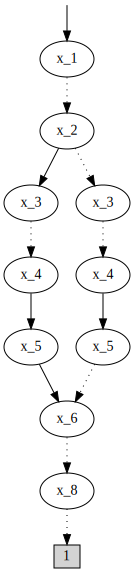

In [28]:
import graphviz

graphviz.Source(reachable.to_bdd().to_dot())

In [29]:
# We need to copy an existing set to preserve all metadata about the model,
# since these are not saved in the BDD
reachable_reloaded = ColoredVertexSet(graph, Bdd.from_raw_string(reachable_string))

# r1 <=> r2 must be a tautology if the sets are equivalent:
reachable_reloaded.to_bdd().l_iff(reachable.to_bdd()).is_true()

True

However, keep in mind that the raw string does not contain any information about the underlying model, and you cannot mix BDD representations between different models! So always make sure not to mix BDD files for different models.